In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import corner
from jnkepler.jaxttv import *
from jnkepler.jaxttv.utils import elements_to_pdic, params_to_elements
from jax import config
import numpyro, jax
config.update('jax_enable_x64', True)
numpyro.set_platform('cpu')
num_chains = 4
numpyro.set_host_device_count(num_chains)
print ('# jax device count:', jax.local_device_count())

# jax device count: 4


In [2]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
plt.rcParams["figure.figsize"] = (12,6)
from matplotlib import rc
rc('text', usetex=True)

### define tcobs, errorobs, p_init, timestep dt, start/end times of integration
- lists of length = (# of planets)
- elements of tcobs and errorobs: arrays of transit times and errors for each planet
- elements of p_init: (reasonably) good guesses for planets' mean periods

In [4]:
d = pd.read_csv("kep51/ttv.txt", delim_whitespace=True, header=None, names=['tnum', 'tc', 'tcerr', 'dnum', 'planum'])
tcobs = [jnp.array(d.tc[d.planum==j+1]) for j in range(3)]
errorobs = [jnp.array(d.tcerr[d.planum==j+1]) for j in range(3)]
p_init = [45.155305, 85.31646, 130.17809]
dt = 1.0
t_start, t_end = 155., 2950.

/var/folders/qp/91qlh0v11sb02z6vb4nb_s0m0000gn/T/ipykernel_7388/3010500145.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  d = pd.read_csv("kep51/ttv.txt", delim_whitespace=True, header=None, names=['tnum', 'tc', 'tcerr', 'dnum', 'planum'])


### initialize JaxTTV class

In [5]:
jttv = JaxTTV(t_start, t_end, dt, tcobs, p_init, errorobs=errorobs, print_info=True)

# integration starts at:           155.00
# first transit time in data:      159.11
# last transit time in data:       2945.75
# integration ends at:             2950.00
# integration time step:           1.0000 (1/45 of innermost period)

# number of transiting planets:      3


### least-squares fit for initializing HMC
- defaults to LM optimization with scipy.optimize.curve_fit
- if a good guess is not found, turning on amoeba may help
- this implements only a very simple optimization; one could write a more ellaborate one if necessary

In [6]:
params_best, _ = jttv.optim(mmax=1e-4, emax=0.1)

initial objective function: 5448.23 (53 data)

running optimization...
objective function: 47.72 (53 data)
# elapsed time (least square): 1.8 sec


### show the 'best-fit' parameters found

In [7]:
elements, masses = params_to_elements(params_best, jttv.nplanet)
pdic = pd.DataFrame(elements_to_pdic(elements, masses))
print (pdic)

      pmass      period     ecosw     esinw  cosi  lnode         tic  \
0  3.263798   45.154104 -0.017151 -0.041028   0.0   -0.0  159.110260   
1  4.071885   85.314477  0.019277 -0.035540  -0.0    0.0  295.321045   
2  5.304152  130.184123  0.011986 -0.028696  -0.0    0.0  212.023426   

        ecc     omega     lnmass      mass      cosw      sinw  
0  0.044468 -1.966740 -11.532844  0.000010 -0.385679 -0.922633  
1  0.040432 -1.073812 -11.311630  0.000012  0.476777 -0.879024  
2  0.031098 -1.175124 -11.047246  0.000016  0.385429 -0.922738  


### setup and run HMC
- pdic_init: dict containing best-fit values
- tic_guess: used to set priors for times of inferior conjunction
- p_guess: used to set priors for osculating periods

In [24]:
from numpyro.infer import init_to_value
import numpyro.distributions as dist
import jax.random as random

tic_guess = jnp.array([_tcobs[0] for _tcobs in jttv.tcobs])
p_guess = jnp.array(jttv.p_init)
ones = jnp.ones_like(p_guess)


def model(dp=5e-1, dtic=1e-1, emax=0.3, mmin=1e-7, mmax=1e-3, uniform_mass=False, tcjitter=None):
    tic_scaled = numpyro.sample("tic_scaled", dist.Uniform(low=-0.5*ones, high=0.5*ones)) 
    period_scaled =  numpyro.sample("period_scaled", dist.Uniform(low=-0.5*ones, high=0.5*ones))
    ecosw_scaled = numpyro.sample("ecosw_scaled", dist.Uniform(-0.5*ones, 0.5*ones))
    esinw_scaled = numpyro.sample("esinw_scaled", dist.Uniform(-0.5*ones, 0.5*ones))
    lnode = numpyro.deterministic("lnode", ones*0)
    cosi = numpyro.deterministic("cosi", ones*0)

    tic = numpyro.deterministic("tic", tic_scaled * 2 * dtic + tic_guess)
    period = numpyro.deterministic("period", period_scaled * 2 * dp + p_guess)
    ecosw = numpyro.deterministic("ecosw", ecosw_scaled * 2 * emax)
    esinw = numpyro.deterministic("esinw", esinw_scaled * 2 * emax)
    ecc = numpyro.deterministic("ecc", jnp.sqrt(ecosw**2+esinw**2))
    omega = numpyro.deterministic("omega", jnp.arctan2(esinw, ecosw))
    numpyro.factor("eprior", -jnp.log(ecc)) # for uniform e prior; for log-uniform e prior, use -2*jnp.log(ecc) instead
    
    if uniform_mass:
        mass_scaled = numpyro.sample("mass_scaled", dist.Uniform(low=ones*0, high=ones))
        mass = numpyro.deterministic("mass", mass_scaled * (mmax - mmin) + mmin)
        numpyro.deterministic("lnmass", jnp.log(mass))
    else:
        lnmass_scaled = numpyro.sample("lnmass_scaled", dist.Uniform(low=ones*0, high=ones))
        lnmass = numpyro.deterministic("lnmass", lnmass_scaled * jnp.log(mmax/mmin) + jnp.log(mmin))
        mass = numpyro.deterministic("mass", jnp.exp(lnmass))

    elements = numpyro.deterministic("elements", jnp.array([period, ecosw, esinw, cosi, lnode, tic]).T)
    masses = numpyro.deterministic("masses", jnp.hstack([1., mass]))
    tcmodel, ediff = jttv.get_ttvs(elements, masses)
    numpyro.deterministic("ediff", ediff)
    numpyro.deterministic("tcmodel", tcmodel)
    
    # assuming gaussian likelihood (+ common "jitter")
    if tcjitter is not None:
        lntcjitter = numpyro.sample("lntcjitter", dist.Uniform(low=-10, high=jnp.log(tcjitter)))
        tcjitter = numpyro.deterministic("tcjitter", jnp.exp(lntcjitter))
        tcerrmodel = jnp.sqrt(jttv.errorobs_flatten**2 + tcjitter**2)
    else:
        tcerrmodel = jttv.errorobs_flatten     
    numpyro.sample("obs", dist.Normal(loc=tcmodel, scale=tcerrmodel), obs=jttv.tcobs_flatten)

In [25]:
pdic_init = elements_to_pdic(*params_to_elements(params_best, jttv.nplanet), 
                             outkeys=['period', 'ecc', 'cosw', 'sinw', 'cosi', 'lnode', 'tic', 'lnmass', 'mass'])
pdic_init['ecosw_scaled'] = pdic_init['ecc'] * pdic_init['cosw'] / 2. / 0.3
pdic_init['esinw_scaled'] = pdic_init['ecc'] * pdic_init['sinw'] / 2. / 0.3
pdic_init['tic_scaled'] = (pdic_init['tic'] - tic_guess) / 2. / 0.1
pdic_init['period_scaled'] = (pdic_init['period'] - p_guess) / 2. / 0.5
pdic_init['mass_scaled'] = pdic_init['mass'] / 5e-4
init_strategy = init_to_value(values=pdic_init)

In [26]:
pdic_init

{'period': Array([ 45.15410448,  85.31447685, 130.18412336], dtype=float64),
 'cosi': Array([ 0., -0., -0.], dtype=float64),
 'lnode': Array([-0.,  0.,  0.], dtype=float64),
 'tic': Array([159.11026002, 295.32104539, 212.02342613], dtype=float64),
 'ecc': Array([0.04446838, 0.04043161, 0.03109836], dtype=float64),
 'lnmass': Array([-11.53284415, -11.31162971, -11.04724585], dtype=float64),
 'mass': Array([9.80278386e-06, 1.22298642e-05, 1.59309651e-05], dtype=float64),
 'cosw': Array([-0.38567937,  0.4767767 ,  0.38542887], dtype=float64),
 'sinw': Array([-0.92263288, -0.87902445, -0.92273755], dtype=float64),
 'ecosw_scaled': Array([-0.02858423,  0.03212808,  0.01997701], dtype=float64),
 'esinw_scaled': Array([-0.06837999, -0.05923396, -0.04782604], dtype=float64),
 'tic_scaled': Array([ 0.00030011,  0.02347697, -0.00381937], dtype=float64),
 'period_scaled': Array([-0.00120052, -0.00198315,  0.00603336], dtype=float64),
 'mass_scaled': Array([0.01960557, 0.02445973, 0.03186193], dty

In [27]:
kernel = numpyro.infer.NUTS(model, init_strategy=init_strategy, dense_mass=True, regularize_mass_matrix=False)
nw, ns, linear_mass_prior, tcjitter = 500, 1500, True, None

In [28]:
assert num_chains <= jax.local_device_count()
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns, num_chains=num_chains)

In [29]:
output = "kep51/dmm_noregMM_dt%.1f_"%jttv.dt
if not linear_mass_prior:
    output += "logm"
if tcjitter is not None:
    output += "jit"
output += "nw%d_ns%d_"%(nw, ns)
if num_chains > 1:
    output += "c%d_"%num_chains

In [30]:
output

'kep51/dmm_noregMM_dt1.0_nw500_ns1500_c4_'

In [31]:
import os, dill
posterior = output + "mcmc.pkl"
if os.path.exists(posterior):
    print (posterior + " loaded.")
    mcmc = dill.load(open(posterior, 'rb'))
else:
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, mmin=0, mmax=5e-4, uniform_mass=linear_mass_prior, tcjitter=tcjitter)
    with open(output+"mcmc.pkl", "wb") as f:
        dill.dump(mcmc, f)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

### summary statistics

In [32]:
mcmc.print_summary()


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
 ecosw_scaled[0]     -0.03      0.01     -0.03     -0.05     -0.01   1878.26      1.00
 ecosw_scaled[1]      0.01      0.02      0.01     -0.02      0.03   1589.97      1.00
 ecosw_scaled[2]      0.00      0.01     -0.00     -0.02      0.02   1577.67      1.00
 esinw_scaled[0]     -0.04      0.02     -0.04     -0.07     -0.01   1164.45      1.00
 esinw_scaled[1]     -0.01      0.02     -0.00     -0.05      0.02    832.72      1.00
 esinw_scaled[2]     -0.01      0.02     -0.00     -0.04      0.02    822.35      1.00
  mass_scaled[0]      0.02      0.01      0.02      0.01      0.04    732.59      1.00
  mass_scaled[1]      0.03      0.00      0.03      0.02      0.03   1418.77      1.00
  mass_scaled[2]      0.04      0.01      0.03      0.02      0.05   2033.12      1.00
period_scaled[0]     -0.00      0.00     -0.00     -0.00     -0.00   1597.41      1.00
period_scaled[1]     -0.00      0.00     -

In [33]:
samples = mcmc.get_samples()

### trace plots

In [34]:
M_earth = 3.0034893e-6
samples['pmass'] = samples['mass'] / M_earth 
#samples['ecc'] = samples['ecosw'] 

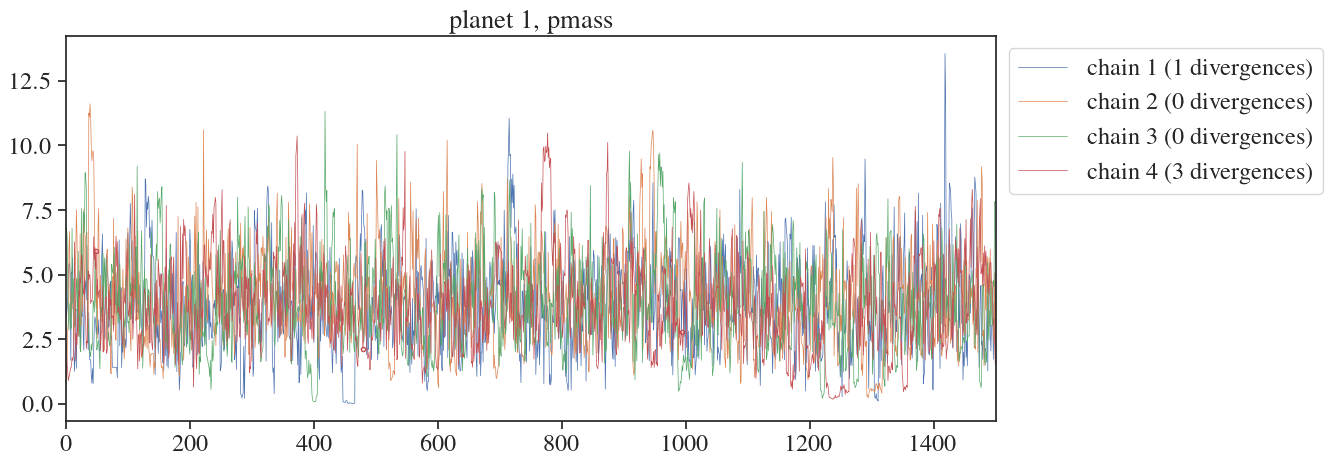

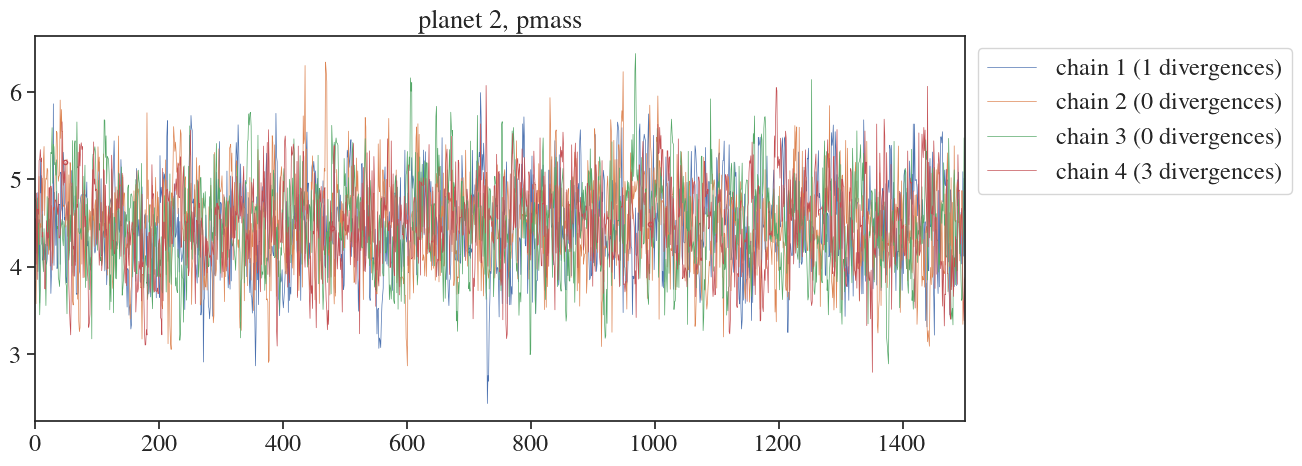

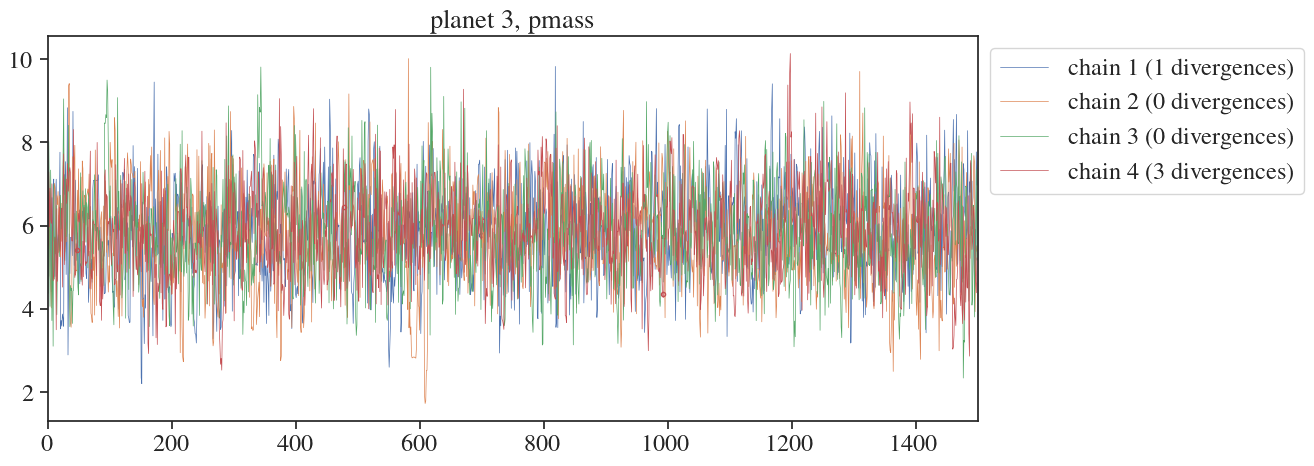

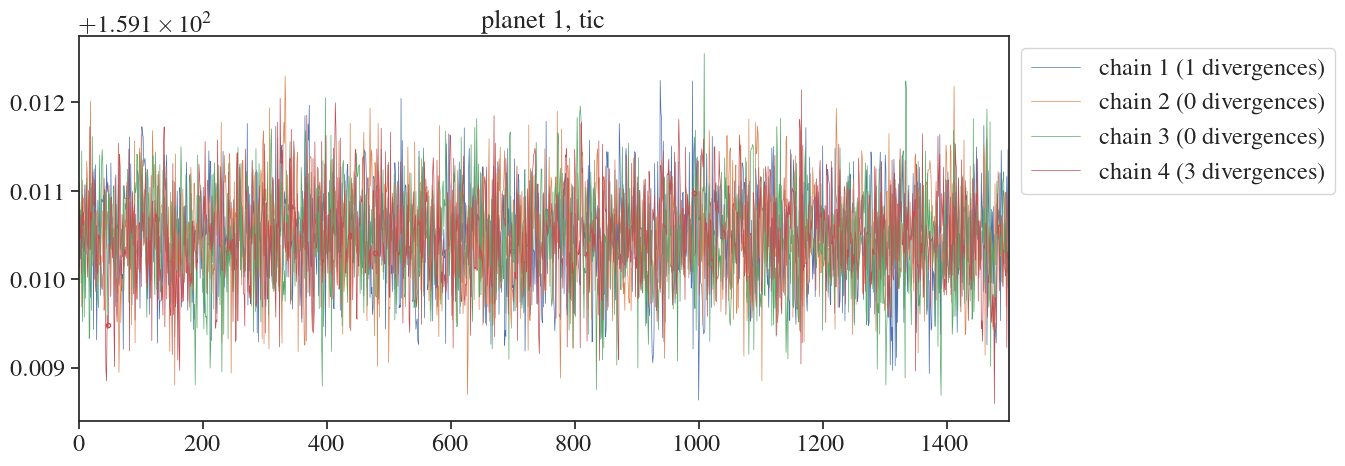

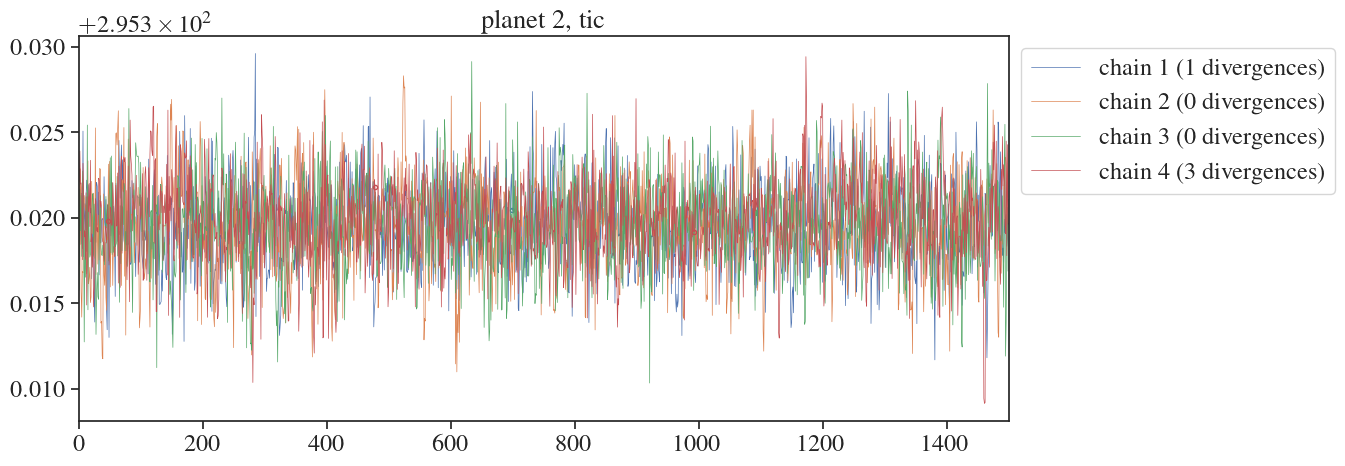

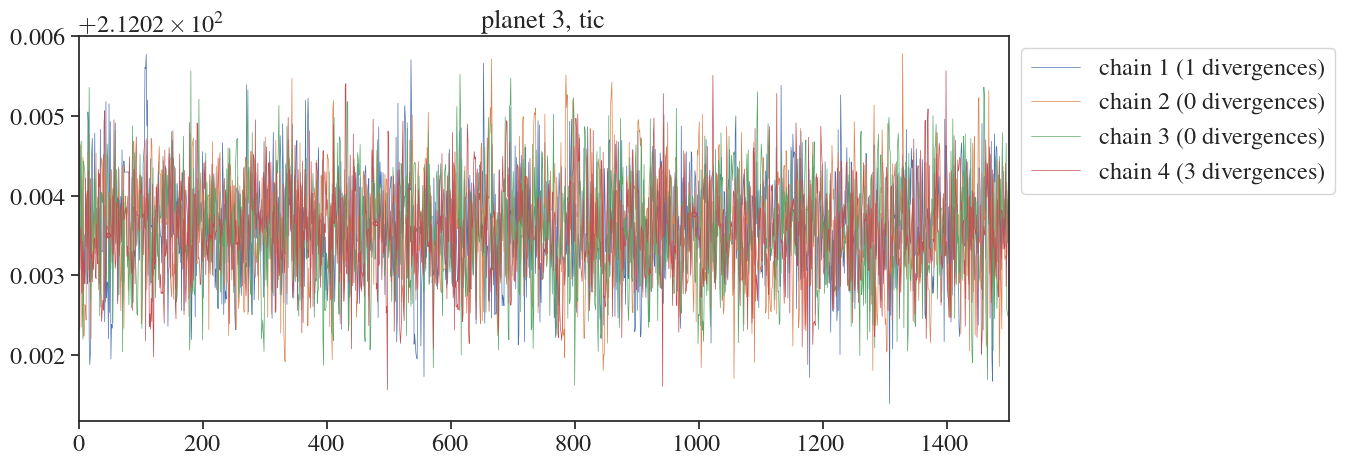

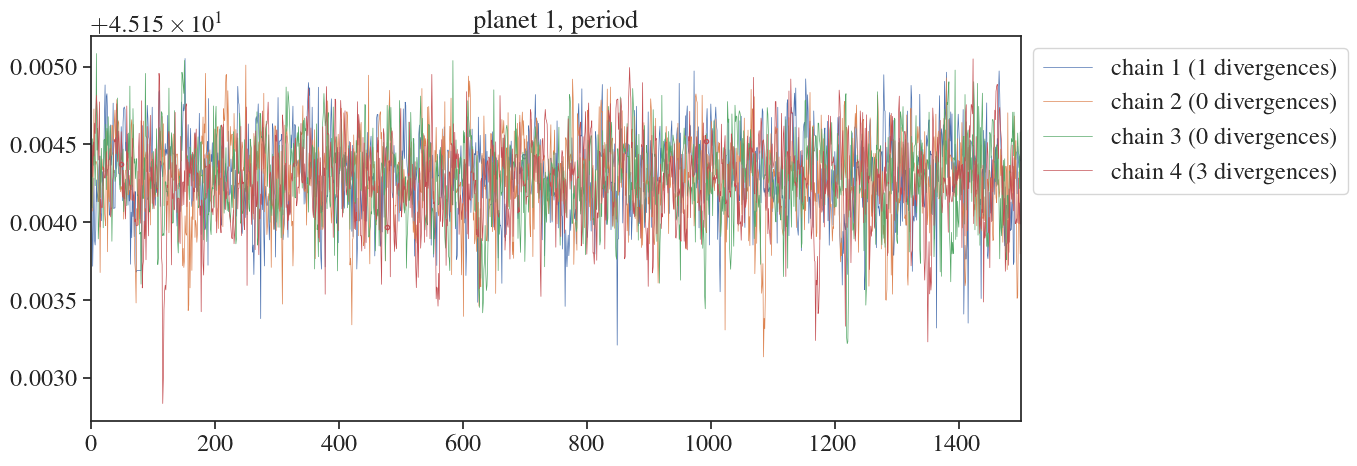

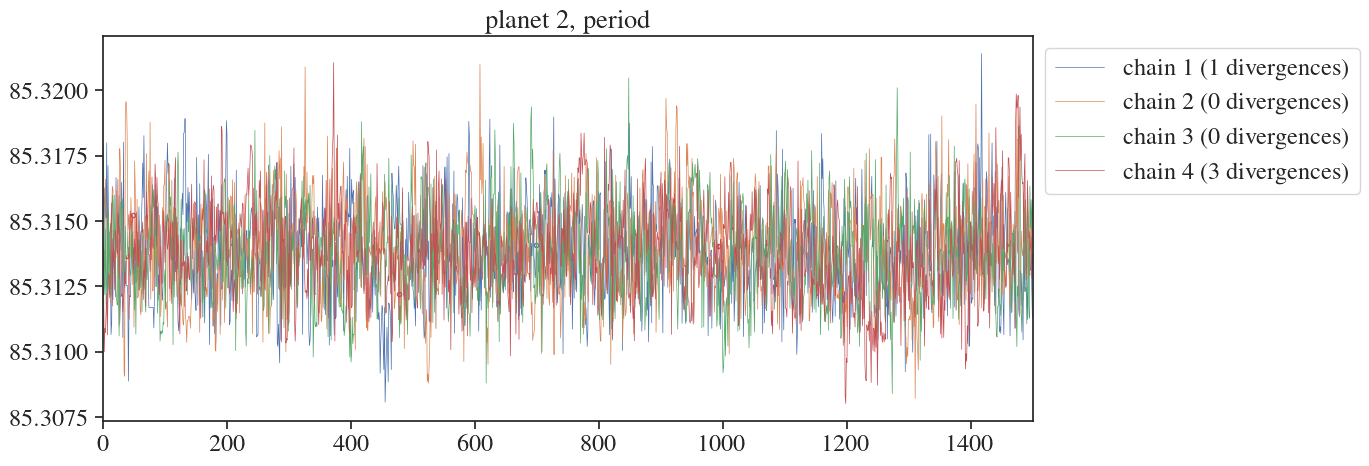

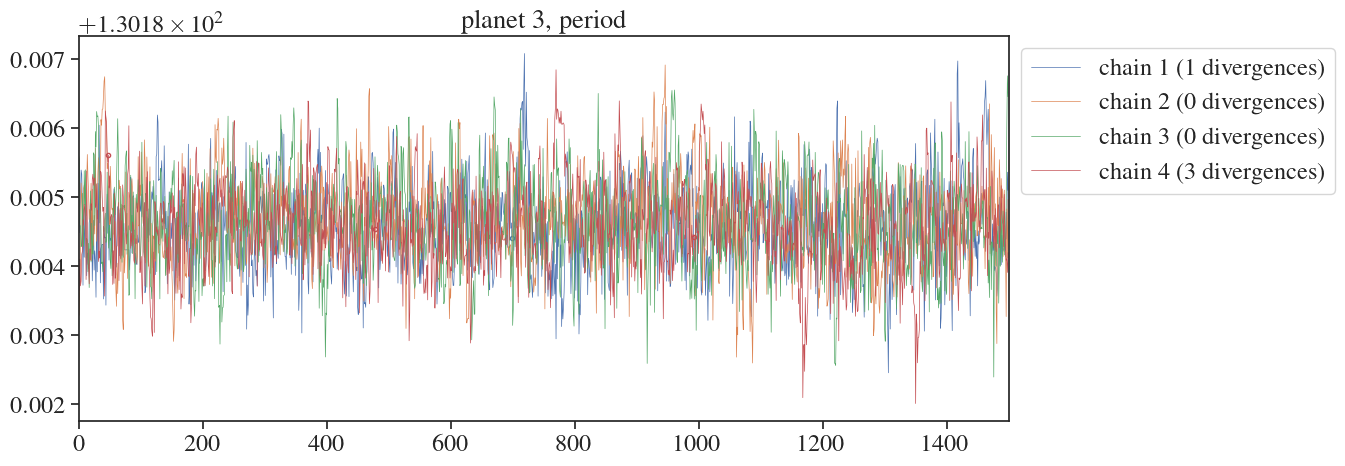

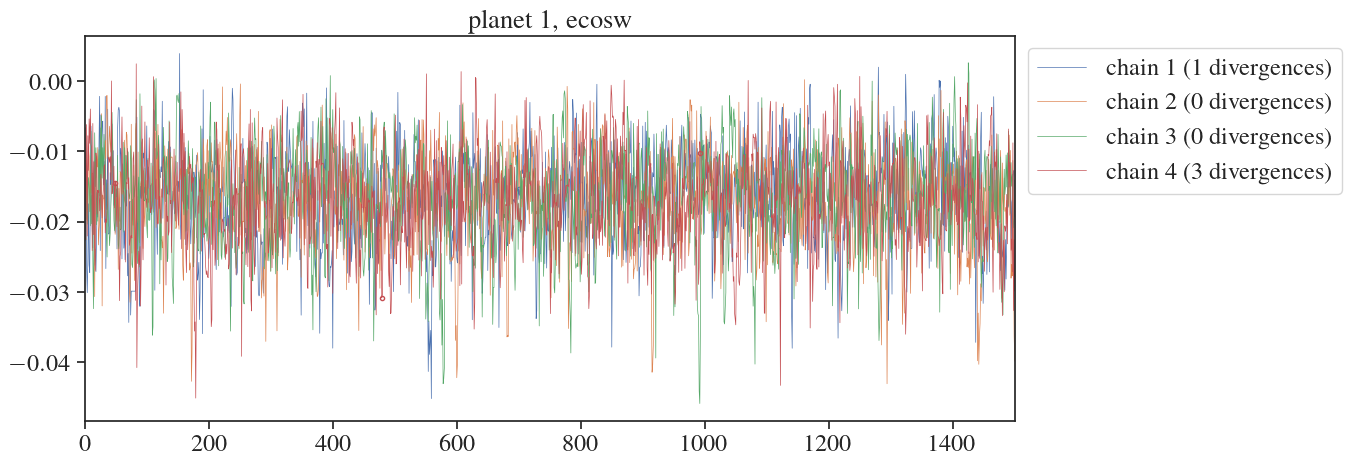

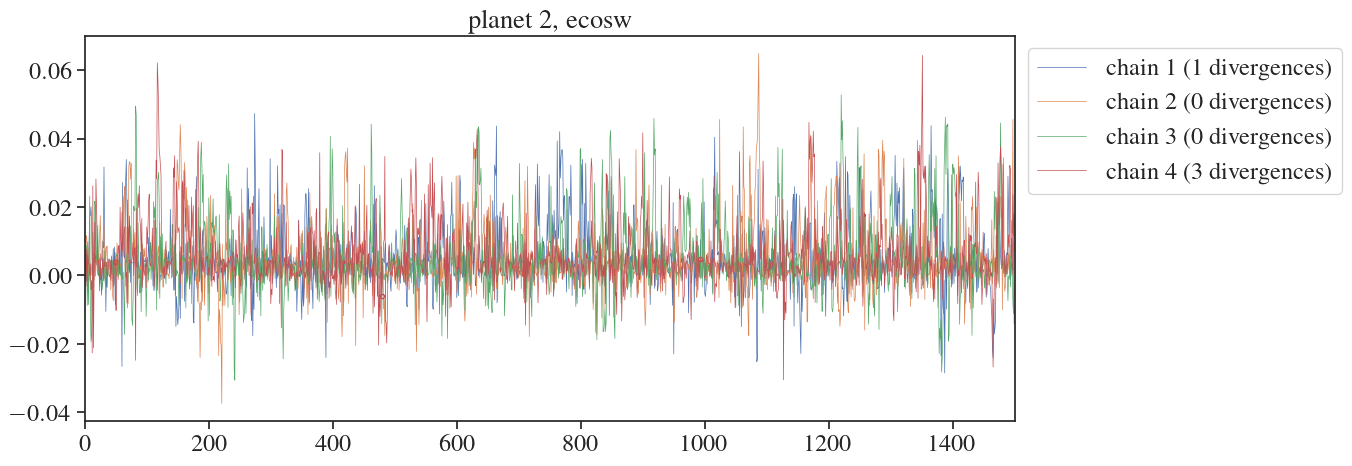

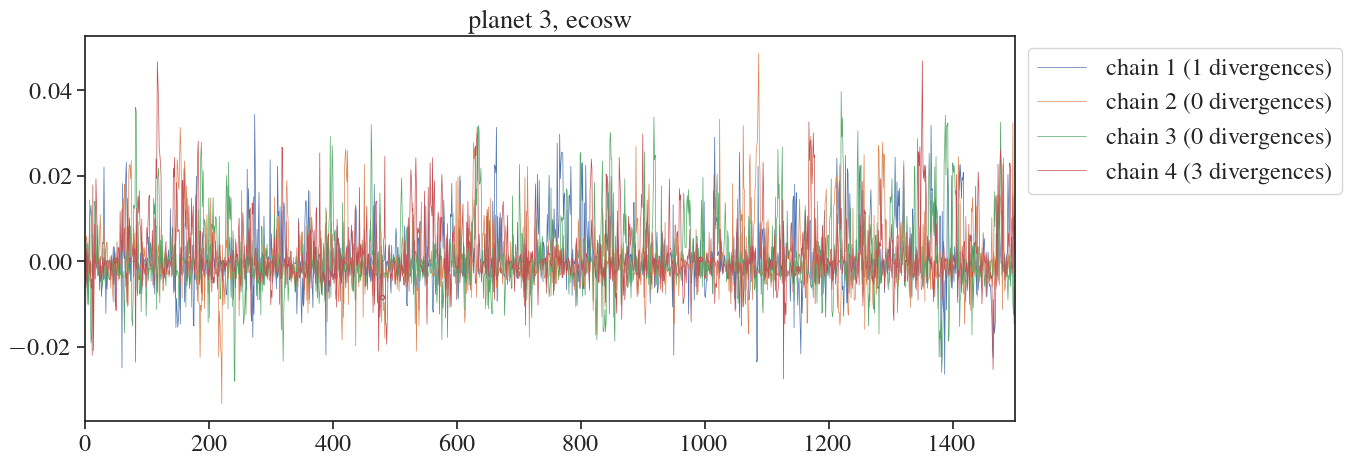

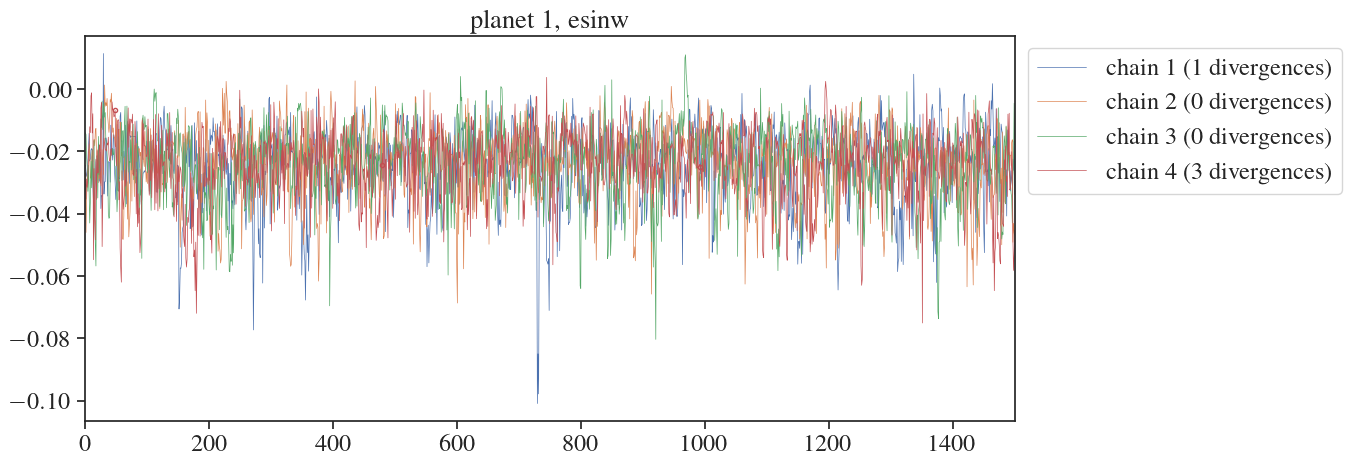

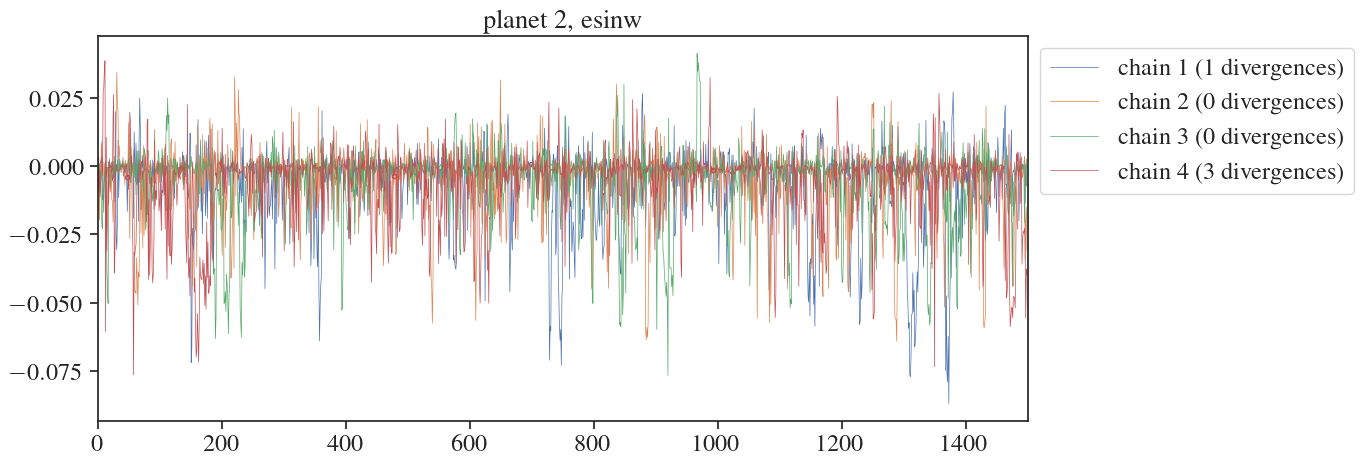

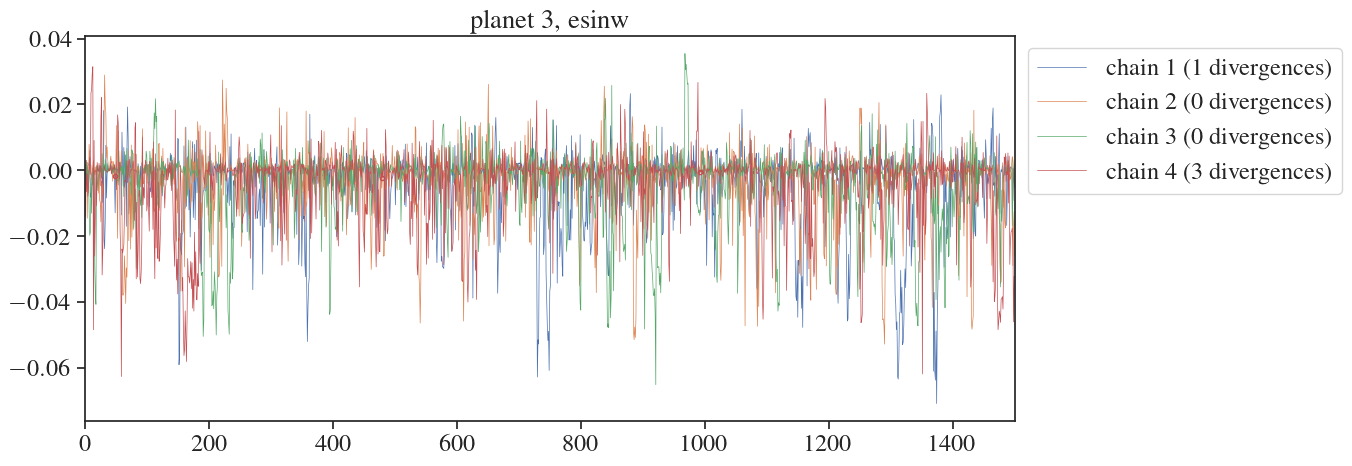

In [35]:
divs = np.array(mcmc.get_extra_fields(group_by_chain=True)['diverging'])
keys = ['pmass', 'tic', 'period', 'ecosw', 'esinw']
for k in keys:
    if num_chains == 1:
        smp_ = samples[k][None,:]
    else:
        smp_ = samples[k].reshape(num_chains,-1,samples[k].shape[1])
    for j in range(jttv.nplanet):
        plt.figure(figsize=(12,5))
        plt.title("planet %d, %s"%((j+1), k))
        plt.xlim(0, np.shape(smp_)[1])
        for l in range(num_chains):
            s = smp_[l,:,j]
            plt.plot(s, lw=0.5, color='C%d'%l, label='chain %d (%d divergences)'%(l+1, np.sum(divs[l,:])))
            _s = np.array(smp_[l,:,j])
            _s[~divs[l,:]]= np.nan
            plt.plot(_s, 'o', mew=1, mfc='none', color='C%d'%l, markersize=3)
        plt.legend(loc='best', bbox_to_anchor=(1,1))

### corner plots

In [36]:
keys = ['pmass', 'tic', 'period', 'ecc', 'omega']

In [23]:
for j in range(jttv.nplanet):
    hyper = pd.DataFrame(data=dict(zip(keys, [samples[k][:,j] for k in keys])))
    if tcjitter is not None:
        hyper['lntcjitter'] = samples['lntcjitter']
        labels = keys + ['lntcjitter']
    else:
        labels = keys
    fig = corner.corner(hyper, labels=labels, show_titles=True, title_fmt=".4f")
    #plt.savefig(output+"corner%d.png"%(j+1), dpi=200, bbox_inches="tight");